# Consumer Financial Protection Bureau - Consumer Complaints
## Exploratory Data Analysis - Part 2

### Loading required Libraries

In [33]:
library(readr)
library(dplyr)
library(ggplot2)
library(quanteda)
library(RColorBrewer)
library(wordcloud)
library(openxlsx)
library(datasets)

### Loading the data set

In [34]:
data <- read_csv("cc.csv", na = c("NA", "N/A", NULL, ""), progress = TRUE)
glimpse(data)

Parsed with column specification:
cols(
  complaint_id = col_integer(),
  date_received = col_datetime(format = ""),
  date_sent_to_company = col_datetime(format = ""),
  company = col_character(),
  product = col_character(),
  sub_product = col_character(),
  issue = col_character(),
  submitted_via = col_character(),
  company_public_response = col_character(),
  state = col_character(),
  zip_code = col_character(),
  company_response = col_character(),
  consumer_disputed = col_character(),
  sub_issue = col_character(),
  complaint_what_happened = col_character(),
  consumer_consent_provided = col_character(),
  timely = col_character(),
  tags = col_character()
)


|=================================================================| 100%  576 MB
Observations: 1,078,137
Variables: 18
$ complaint_id              <int> 14372, 1216062, 1357172, 1770766, 868283,...
$ date_received             <dttm> 2012-01-17, 2015-01-29, 2015-05-01, 2016...
$ date_sent_to_company      <dttm> 2012-01-20, 2015-01-29, 2015-05-01, 2016...
$ company                   <chr> "JPMORGAN CHASE & CO.", "RFNA, LP", "BANK...
$ product                   <chr> "Mortgage", "Debt collection", "Mortgage"...
$ sub_product               <chr> "Conventional fixed mortgage", "Other (i....
$ issue                     <chr> "Loan modification,collection,foreclosure...
$ submitted_via             <chr> "Phone", "Web", "Web", "Fax", "Web", "Ref...
$ company_public_response   <chr> NA, NA, NA, NA, NA, "Company chooses not ...
$ state                     <chr> "CA", "SC", "PA", "MD", "CA", "VA", "PA",...
$ zip_code                  <chr> "94404", "29657", "15063", "21239", "9211...
$ company_re

#### Exploring the Relationship between complaints and S&P500 Index as well as Down Jones Industrial Average

S&P500 and DJIA are the two very famous Index which map the latest scenario of the stock market. S&P500 comprises of a moving average of 500 companies where as DJIA comprises of a mathematical smoothing of 30 big companies of the US.

The key identifier which links these indexes (I think!) is the fact that the major companies that are included in S&P500 and DJIA are financial in nature and have to do with Loans, Credit services, Mortgages, Debt Collections etc.

Hence, if we are able to find out any trivial relationships between specific product complaints and the fluctuations in these indexes, we would be able to conculde a good identifier for predicting the Complaints a company can have in coming future. This edge, can help the company modify its customer relationships and eventually will help the company deliver a better experience to the consumer.

To begin with,

    1. Found out the Total Complaints between Year 2015 to 2017
    2. Filtered Mortgages, Vehical loans and Credit Card related issues

In [35]:
data_c <- data
data_c$Year <- lubridate::year(data_c$date_received)
data_c$Month <- lubridate::month(data_c$date_received)#, label = TRUE)
data_cc <- data_c %>% group_by(Year, Month) %>% summarise(Total_Complaints = n()) %>%
  filter(Year >= 2015 & Year <= 2017)
head(data_cc)

Year,Month,Total_Complaints
2015,1,12629
2015,2,12684
2015,3,14519
2015,4,13758
2015,5,13687
2015,6,14519


In [36]:
indexes <- c("Mortgage", "Vehicle loan or lease", "Credit card")
data_i <- data %>% filter(product %in% indexes)
data_i$Year <- lubridate::year(data_i$date_received)
data_i$Month <- lubridate::month(data_i$date_received)#, label = TRUE)
data_ii <- data_i %>% group_by(Year, Month) %>% summarise(Total_Complaints = n()) %>%
  filter(Year >= 2015 & Year <= 2017)
data_ii$Proportion.of.Total <- data_ii$Total_Complaints / data_cc$Total_Complaints
head(data_ii)

Year,Month,Total_Complaints,Proportion.of.Total
2015,1,4152,0.3287671
2015,2,4445,0.3504415
2015,3,5019,0.3456850
2015,4,5021,0.3649513
2015,5,5046,0.3686710
2015,6,5407,0.3724086


#### Reading the DJIA and S&P500 data

In [37]:
spi <- read.csv("SP500.csv")
spi$SP500 <- as.numeric(as.character(spi$SP500))
spi$Month <- lubridate::month(spi$DATE)
spi$Year <- lubridate::year(spi$DATE)
spi <- spi %>% filter(Year >= 2015 & Year <= 2017)
spi_new <- spi %>% group_by(Year, Month) %>% summarise(Avg = mean(SP500, na.rm = TRUE))
head(spi_new)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Year,Month,Avg
2015,1,2028.178
2015,2,2082.196
2015,3,2079.990
2015,4,2094.863
2015,5,2111.943
2015,6,2099.284


In [38]:
dji <- read.csv("DJIA.csv")
dji$DJIA <- as.numeric(as.character(dji$DJIA))
dji$Month <- lubridate::month(dji$DATE)
dji$Year <- lubridate::year(dji$DATE)
dji <- dji %>% filter(Year >= 2015 & Year <= 2017)
dji_new <- dji %>% group_by(Year, Month) %>% summarise(Avg_DJIA = mean(DJIA, na.rm = TRUE))
head(dji_new)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Year,Month,Avg_DJIA
2015,1,17542.26
2015,2,17945.41
2015,3,17931.74
2015,4,17970.51
2015,5,18124.71
2015,6,17927.22


#### Combinig S&P500 and DJIA data with Total mumber of Complaints received for select product complaints

In [39]:
data_ii$SP500 <- spi_new$Avg
data_ii$Time <- paste0(data_ii$Month,"/",data_ii$Year)
data_ii$DJIA <- dji_new$Avg_DJIA
head(data_ii)

Year,Month,Total_Complaints,Proportion.of.Total,SP500,Time,DJIA
2015,1,4152,0.3287671,2028.178,1/2015,17542.26
2015,2,4445,0.3504415,2082.196,2/2015,17945.41
2015,3,5019,0.3456850,2079.990,3/2015,17931.74
2015,4,5021,0.3649513,2094.863,4/2015,17970.51
2015,5,5046,0.3686710,2111.943,5/2015,18124.71
2015,6,5407,0.3724086,2099.284,6/2015,17927.22


##### Analyzing Correlations between S&P500 & DJIA with Complaints for Mortgage, Vehical Loan and Credit Card of the Total

In [40]:
print(paste("Correlation of S&P500 index with  Proportion of Total:",
            cor(data_ii$Proportion.of.Total, data_ii$SP500)))

[1] "Correlation of S&P500 index with  Proportion of Total: -0.933300594213206"


In [41]:
print(paste("Correlation of DJIA index with  Proportion of Total:",
            cor(data_ii$Proportion.of.Total, data_ii$DJIA)))

[1] "Correlation of DJIA index with  Proportion of Total: -0.930559563305166"


The correlation between *S&P500 index with the Proportion of Complaints that include Mortgage,
Auto Loans and Credit Card related issues* is found to be **-0.9333** which is a very high negative number. 
This shows their is a **negative relationship** between the S&P500 index and the proportion of Complaints that include Mortgages, auto loans and credit cards.

Similarly, the correlation index for *DJIA with the Proportion of Complaints that include Mortgage,
Auto Loans and Credit Card related issues* is found to be **-0.9305** which is also a very high number that shows evident proof of a **negative realtionship** between the DJIA index and the proportion of Complaints that include Mortgages, auto loans and credit cards.

As DJIA and S&P500 moreover represent the same thing, the results are quite promising. There is a **strong proof of negative correaltion between the indexes and the Proportion of Total Complaints that inculde Mortgage, Auto Loans and Credit cards.**

In other words, with ***increase in S&P500 index / DJIA, complaints for Mortgage, Auto Loans and Credit cards decreases.***

#### Linear Regression on Proportion of Total with SP500

In [42]:
model_sp <- lm(Proportion.of.Total ~ SP500, data = data_ii)
summary(model_sp)
p1 <- ggplot(data_ii, aes(SP500, Proportion.of.Total)) + geom_jitter(size = 2.5, alpha = 0.6, col = "orange") +
  geom_smooth(stat = "smooth", method = "lm") + theme_light() + 
  ggtitle("Proportion of Complaints with Mortgage, Auto Loans, Credit Card vs SP500",
                subtitle = paste("Correlation:", round(correlations_sp, 4)))


Call:
lm(formula = Proportion.of.Total ~ SP500, data = data_ii)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.065500 -0.021378  0.002529  0.021840  0.053553 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.192e+00  6.012e-02   19.83   <2e-16 ***
SP500       -4.124e-04  2.721e-05  -15.15   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03213 on 34 degrees of freedom
Multiple R-squared:  0.871,	Adjusted R-squared:  0.8673 
F-statistic: 229.7 on 1 and 34 DF,  p-value: < 2.2e-16


#### Linear Regression on Proportion of Total with DJIA

In [43]:
model_djia <- lm(Proportion.of.Total ~ DJIA, data = data_ii)
summary(model_djia)
p2 <- ggplot(data_ii, aes(DJIA, Proportion.of.Total)) + geom_jitter(size = 2.5, alpha = 0.6, col = "brown") +
  geom_smooth(stat = "smooth", method = "lm") + theme_light() +
  ggtitle("Proportion of Complaints with Mortgage, Auto Loans, Credit Card vs DJIA",
          subtitle = paste("Correlation:", round(correlations_djia, 4)))


Call:
lm(formula = Proportion.of.Total ~ DJIA, data = data_ii)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.068069 -0.018696 -0.004051  0.022760  0.057063 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.012e+00  4.939e-02   20.50   <2e-16 ***
DJIA        -3.813e-05  2.573e-06  -14.82   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03276 on 34 degrees of freedom
Multiple R-squared:  0.8659,	Adjusted R-squared:  0.862 
F-statistic: 219.6 on 1 and 34 DF,  p-value: < 2.2e-16


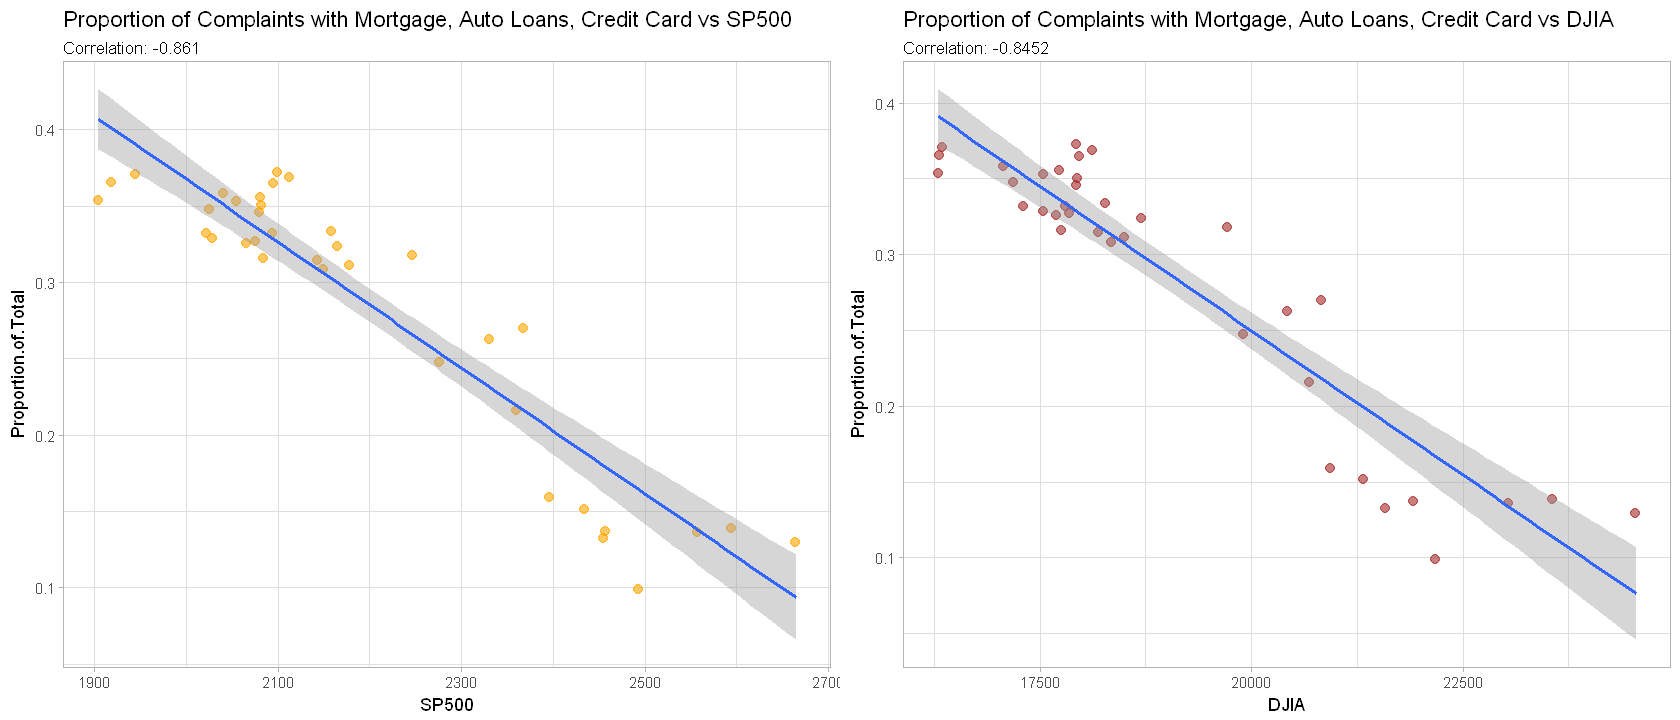

In [44]:
options(repr.plot.width = 14, repr.plot.height = 6)
gridExtra::grid.arrange(p1, p2, ncol = 2)

### Conclusions

    1. Correlation figures for Proportion of Total Complaints which were Mortgage, Auto loans and
    Credit Card are strongly negative
    
    2. Linear regression provides rock solid evidence of the fact that Propotion of these complaints
    are negatively affected by the S&P500 and DJIA index
    
    3. The above plot shows the Proportion of Total vs Indexes and a linear regression model line
    passing through them. We can clearly identify, there is a strong inverse pattern between the two,
    confirming the neagtive relationship
    
    4. P-value statistics for model_sp and model_djia is highly significant. Yet another proof of
    the relationship between the two to be legitimate
    
    5. Found an indicator variable outside the parent data set which can be used to predict the proportion
    of Total complaints for coming years. This information can help, companies deliver better to their
    customers.